In [5]:
import rasterio
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import datetime
import rasterio.mask as mask
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.ticker as ticker


In [6]:
vrt_file_2019='sentinel5_NO2_2019.vrt'
vrt_file_2020='sentinel5_NO2_2020.vrt'
top_folder='/home/dohyungkim/air_pollution/tif'
plot_dir='/home/dohyungkim/air_pollution/plot'

In [7]:
sen5_2019=rasterio.open(os.path.join(top_folder,vrt_file_2019))
sen5_2020=rasterio.open(os.path.join(top_folder,vrt_file_2020))

In [4]:
#for i in range(sen5_2019.count):
#    arr_2019=sen5_2019.read(i+1)
#    arr_2020=sen5_2020.read(i+1)
#    change = arr_2020 - arr_2019
    #print(np.nanmax(arr_2020))
    #print(np.nanmin(arr_2020))
    #print(np.nanmean(arr_2020))
#    out_data = os.path.join(top_folder, 'wk' + str(i+1).zfill(2) + '_avg_anomaly.tif')
#    with rasterio.open(
#                    out_data,
#                    'w',
#                    driver='GTiff',
#                    height=change.shape[0],
#                    width=change.shape[1],
#                    count=1,
#                    dtype=change.dtype,
#                    crs=sen5_2020.crs,
#                    transform=sen5_2020.transform
#    ) as dst:
#        dst.write(change, 1)

# process for plots

In [8]:
country_file='/home/dohyungkim/air_pollution/shp/gadm36_0.shp'
country=gpd.read_file(country_file)

border_file='/home/dohyungkim/air_pollution/shp/gadm36.shp'
boder=gpd.read_file(border_file)

In [9]:
def date_range(start, end):
    r = (end+datetime.timedelta(days=1)-start).days
    #print(r)
    return [start+datetime.timedelta(days=i) for i in range(0,r,7)]


In [10]:
def save_pa(boundary, raster, ISO, year):
    try:
        df = pd.DataFrame(np.nan, index=range(len(sen5_2020.count)), columns=['ISO', 'MEAN','MEDIAN'])
        
        out=os.path.join('/home/dohyungkim/air_pollution/subset',ISO + year +'.tif')

        geom=[boundary['geometry'].values[0]]

        tmp, tmp_transform = mask.mask(raster, geom, crop=True)
        
        with rasterio.open(
                    out,
                    'w',
                    driver='GTiff',
                    height=tmp[0].shape[0],
                    width=tmp[0].shape[1],
                    count=1,
                    dtype=tmp.dtype,
                    crs=raster.crs,
                    transform=tmp_transform
        ) as dst:
            dst.write(tmp[0], 1)    
    
        return((PID,pa_mean))
    except Exception as e:
        print(e)
        return((0,0))
        

In [11]:
def moving_average(y_,window=5):
    return [np.mean(y_[max(0,i-window):i+1]) if i > 0 else y_[i] for i in range(len(y_))]

In [12]:
def get_percent(y1,y2):
    mean=np.nanmean(y1)
    percent=100*(y2-y1)/y1
    return(percent)

In [13]:
sen5_2020.count

18

In [56]:
year=2020
mon_start=1
date_start=1
mon_end=5
date_end=8

start = datetime.date(year,mon_start,date_start)
end = datetime.date(year,mon_end,date_end)
dateList = date_range(start, end)


In [57]:
dates=[str(date)[-5:] for date in dateList]

In [58]:
dates

['01-01',
 '01-08',
 '01-15',
 '01-22',
 '01-29',
 '02-05',
 '02-12',
 '02-19',
 '02-26',
 '03-04',
 '03-11',
 '03-18',
 '03-25',
 '04-01',
 '04-08',
 '04-15',
 '04-22',
 '04-29',
 '05-06']

In [59]:
dates[11]

'03-18'

In [60]:
ISO='CHN'

In [61]:
measures = {'MYS': [(11,'lockdown')],
            'IDN':[(11,'social\ndistancing\nenacted')],
            'IND':[(12,'lockdown')],
            'MEX':[(13,'lockdown')],
            'NGA':[(13,'domestic\ntravel\nrestrictions')],
            'COL':[(10,'health\nemergency\ndeclared')],
            'CIV':[(12,'national\ncurfew')],
            'MMR':[(10,'suspension of\npublic gatherings')],
            'MOZ':[(12,'limit public\ngatherings')],
            'UKR':[(11,'lockdown')],
               }

In [62]:
country_polygons = boder[boder['GID_0']==ISO]
country_name=country_polygons['NAME_0'].values[0]

In [63]:
country_name

'China'

In [64]:
#dissolve for province
province_polygons = country_polygons.dissolve(by='GID_1')

In [65]:
admins=province_polygons['NAME_1'].values

In [66]:
len(admins)

31

In [67]:
df_2019 = pd.DataFrame(np.nan, index=range(len(province_polygons)), columns=dates[:-1])
df_2020 = pd.DataFrame(np.nan, index=range(len(province_polygons)), columns=dates[:-1])

In [68]:
for i in range(len(province_polygons)):
    
    geom=[province_polygons.iloc[[i]]['geometry'].values[0]]
    tmp_2020, tmp_transform = mask.mask(sen5_2020, geom, crop=True)
    tmp_2019, tmp_transform = mask.mask(sen5_2019, geom, crop=True)
    co_mean_2020=np.nanmean(tmp_2020, axis=1)
    co_mean_2020=np.nanmean(co_mean_2020, axis=1)
    co_mean_2019=np.nanmean(tmp_2019, axis=1)
    co_mean_2019=np.nanmean(co_mean_2019, axis=1)
    df_2019.iloc[[i]]=list(co_mean_2019.reshape(-1,1).T)
    df_2020.iloc[[i]]=list(co_mean_2020.reshape(-1,1).T)
    

In [69]:
colors = dict(zip(admins,plt.cm.rainbow(np.linspace(0,1,len(admins)))))

if ISO == 'MYS':
    fs = 12
    sp_x = 4
    sp_y = 4
elif ISO in {'IND','IDN','MEX','COL','CHN'}:
    sp_x = 7
    sp_y = 5
    fs = 10
    offset = 6
elif ISO in {'IND'}:
    sp_x = 6
    sp_y = 6
    fs = 10
    offset = 6
elif ISO == 'NGA':
    sp_x = 8
    sp_y = 5
    fs = 10
elif ISO == 'CIV':
    sp_x = 4
    sp_y = 4
    fs = 12
elif ISO == 'UKR':
    sp_x = 7
    sp_y = 4
    fs = 12
elif ISO == 'MMR':
    sp_x = 5
    sp_y = 3
    fs = 12
elif ISO == 'MOZ':
    sp_x = 4
    sp_y = 3
    fs = 12
else:
    sp_x = 6
    sp_y = 6
    fs = 10
    offset = 6
offset = len(admins)-sp_x

<IPython.core.display.Javascript object>


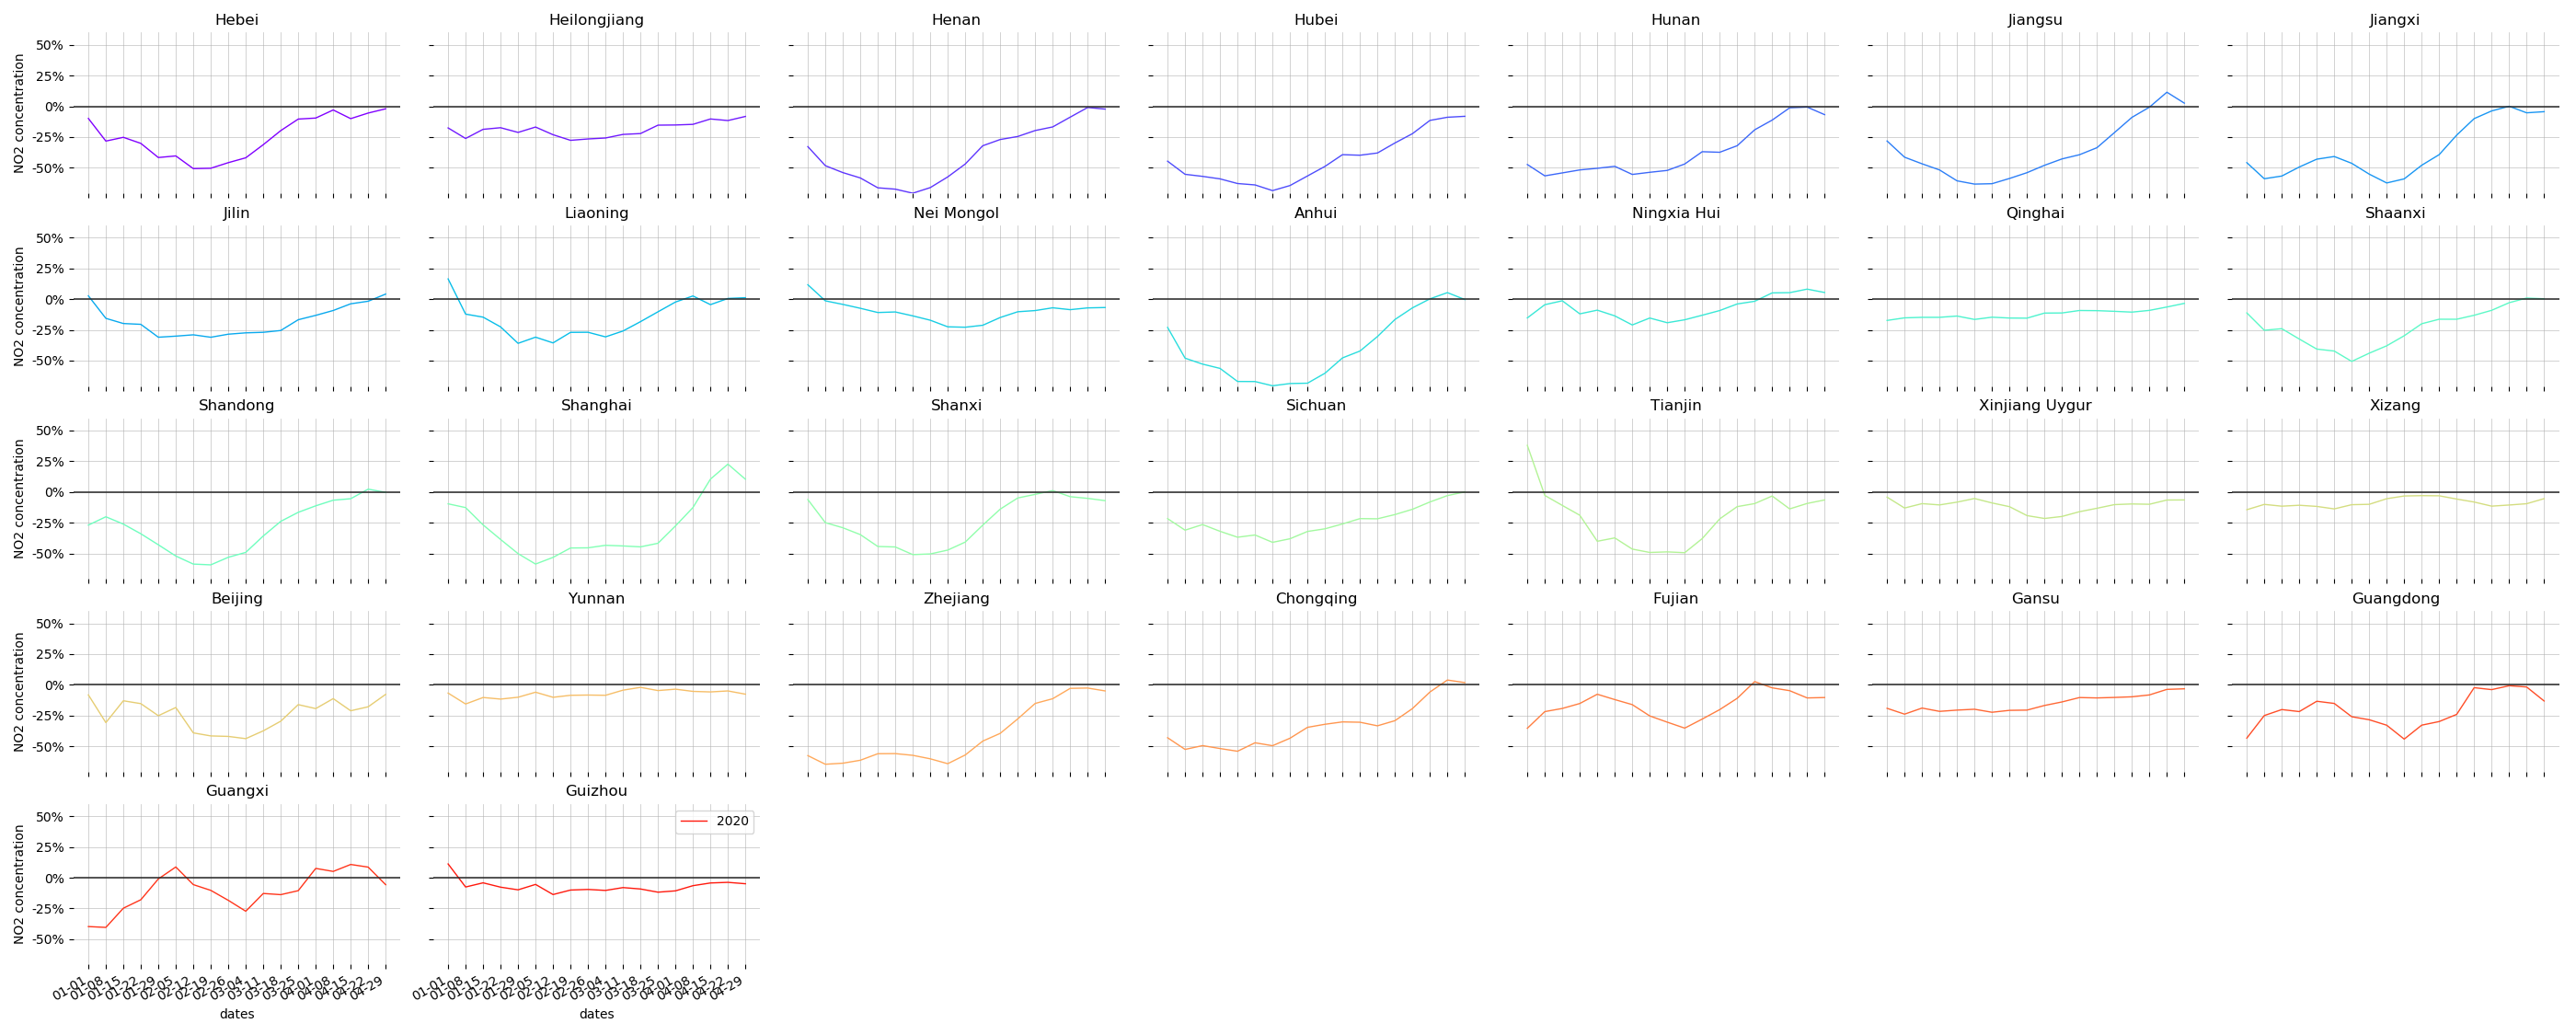

In [70]:
fig, axs = plt.subplots(sp_y,sp_x,figsize=(4*sp_x,2.25*sp_y))
y_max=0
y_min=0

for i in range(sp_x*sp_y):
    ax_x = int(i % sp_x)
    ax_y = int(i / sp_x)
   
    ax = axs[ax_y,ax_x]

    if i <=(len(admins)-2):
        x = dates[:-1]
        y_2020 = df_2020.iloc[[i]]
        y_2019 = df_2019.iloc[[i]]
        # plotting the points
        #ax.plot(x, moving_average(y_2019.values[0],3),color='#FF0000',lw=1,label="2019") 
        #ax.plot(x, moving_average(y_2020.values[0],3),color='#0068ea',lw=1,label="2020") 
        y_=moving_average(get_percent(y_2019.values[0],y_2020.values[0]),3)
        if np.nanmax(y_)>y_max:
            y_max=np.nanmax(y_)
        if np.nanmin(y_)<y_min:
            y_min=np.nanmin(y_)
        ax.plot(x, moving_average(get_percent(y_2019.values[0],y_2020.values[0]),3),color=colors[admins[i]],lw=1,label="2020") 
        #ax.axvline(x=measures[ISO][0][0],lw=1.1,color='red',ls='--',zorder=2,label=measures[ISO][0][1])
        ax.grid(lw=0.5,alpha=0.8,zorder=1)
        # Hide the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # giving a title to my graph 
        ax.set_title(admins[i]) 
    else:
        fig.delaxes(ax)
    

for ax in axs.flat:
    ax.set(xlabel='dates', ylabel='NO2 concentration')
    ax.label_outer()
    y_labels = ax.get_yticks()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))
    ax.axhline(y=0,color='#282828',ls='-',lw=1.1,zorder=2)

    ax.set_ylim(y_min,60)

fig.autofmt_xdate()
plt.legend() 
plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.savefig(os.path.join(plot_dir,ISO + '_subnational.png'),dpi=300,bbox_inches=0,pad=0)



In [776]:
#dissolve for country
country_polygon = country[country['GID_0']==ISO]

In [777]:
df_2019 = pd.DataFrame(np.nan, index=range(len(country_polygon)), columns=dates[:-1])
df_2020 = pd.DataFrame(np.nan, index=range(len(country_polygon)), columns=dates[:-1])

In [778]:
geom=[country_polygon.iloc[[0]]['geometry'].values[0]]
tmp_2020, tmp_transform = mask.mask(sen5_2020, geom, crop=True)
tmp_2019, tmp_transform = mask.mask(sen5_2019, geom, crop=True)
co_mean_2020=np.nanmean(tmp_2020, axis=1)
co_mean_2020=np.nanmean(co_mean_2020, axis=1)
co_mean_2019=np.nanmean(tmp_2019, axis=1)
co_mean_2019=np.nanmean(co_mean_2019, axis=1)
df_2019=list(co_mean_2019.reshape(-1,1).T)
df_2020=list(co_mean_2020.reshape(-1,1).T)
    

<IPython.core.display.Javascript object>


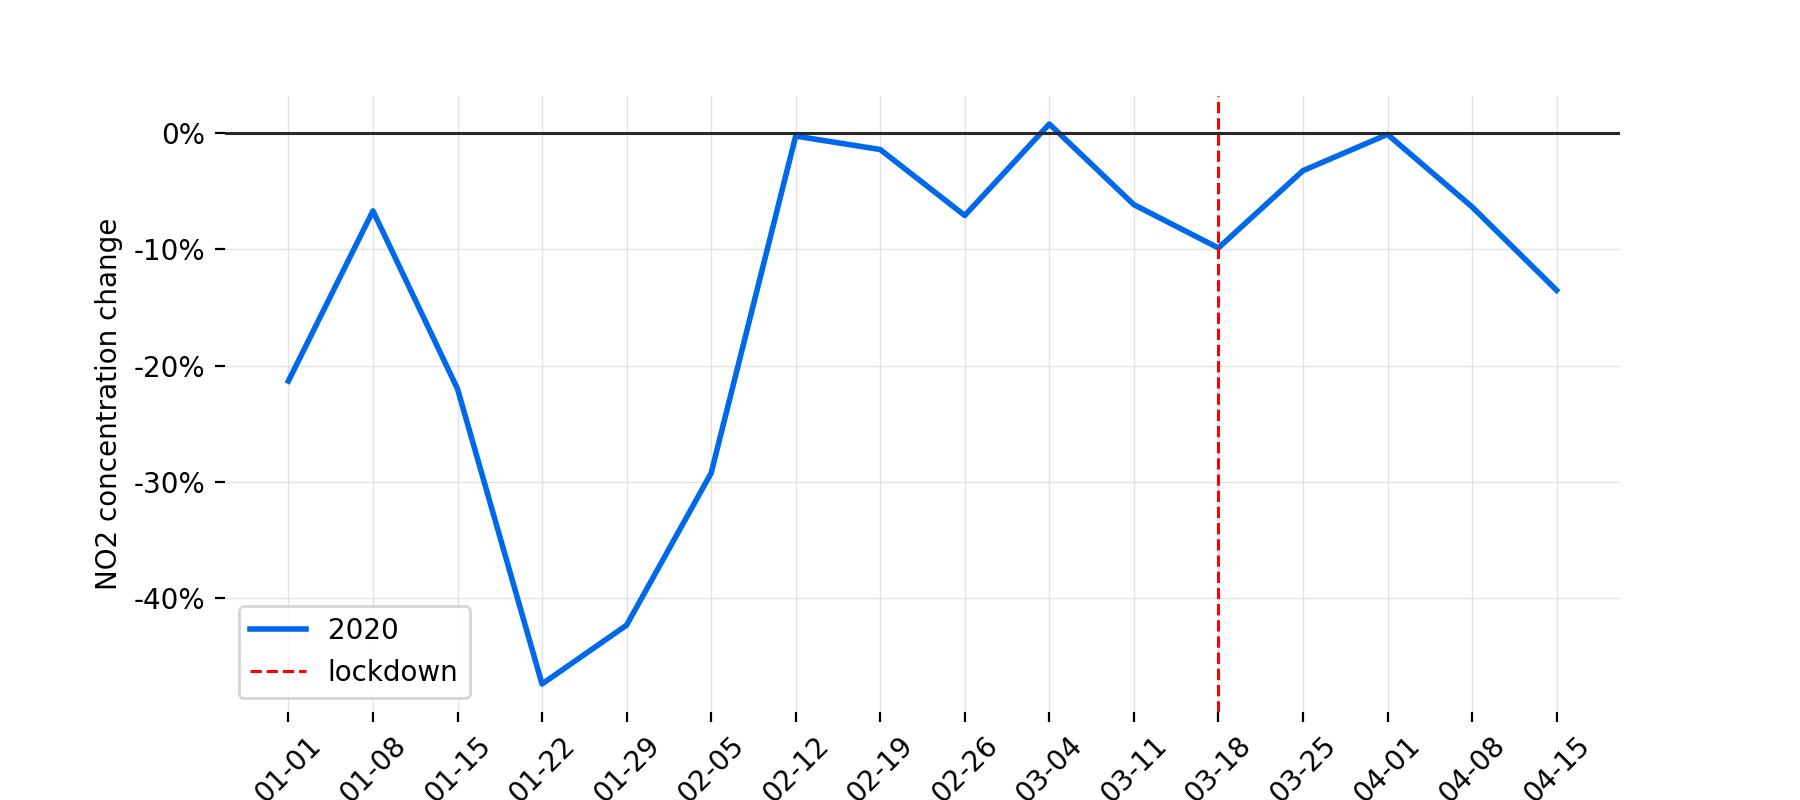

In [779]:
plt.figure(figsize=(9,4))
ax = plt.subplot(111)

x = dates[:-1]
y_2020 = co_mean_2020
y_2019 = co_mean_2019

# plotting the points
#ax.plot(x, moving_average(y_2019,2),color='#FF0000',lw=1,label="2019") 
#ax.plot(x, moving_average(y_2020,2),color='#0068ea',lw=1,label="2020") 
ax.plot(x, moving_average(get_percent(y_2019,y_2020),1),color='#0068ea',lw=2,label="2020") 
ax.axvline(x=measures[ISO][0][0],lw=1.1,color='red',ls='--',zorder=2,label=measures[ISO][0][1])
ax.grid(lw=0.5,alpha=0.8,zorder=1)

# naming the x axis 
#ax.set_xlabel('x - axis') 
# naming the y axis 
ax.set_ylabel('NO2 concentration change') 
plt.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f%%'))
ax.axhline(y=0,color='#282828',ls='-',lw=1.1,zorder=2)
plt.xticks(x, x, rotation=45)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# giving a title to my graph 
#ax.set_title('Air pollution: ' + country_name) 
ax.legend()  

plt.show()
plt.savefig(os.path.join(plot_dir,ISO + '_national.png'),dpi=300,bbox_inches=0,pad=0)



In [780]:
dates[9:13]

['03-04', '03-11', '03-18', '03-25']

<IPython.core.display.Javascript object>


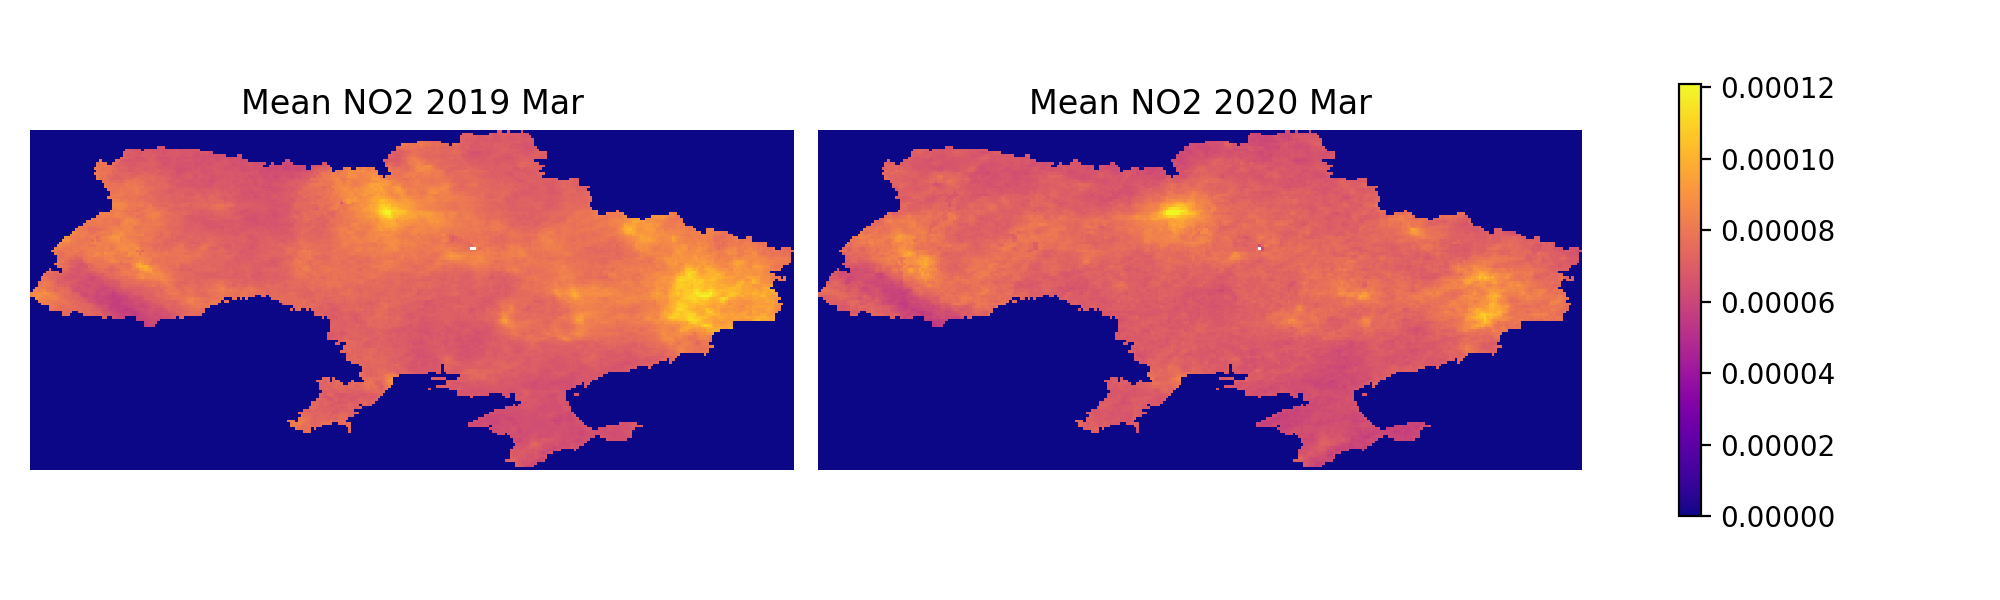

/home/dohyungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/dohyungkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [781]:
fig, axs=plt.subplots(1,2,figsize=(10,3))
mean_2019=np.nanmean(tmp_2019[9:13,:,:],axis=0)
mean_2020=np.nanmean(tmp_2020[9:13,:,:],axis=0)
vmin=np.nanmin(mean_2019)
vmax=np.nanmax(mean_2019)
im = axs[0].imshow(mean_2019,vmin=vmin, vmax=vmax, cmap="plasma")
axs[0].axis('off')
axs[0].set_title('Mean NO2 2019 Mar') 
im = axs[1].imshow(mean_2020,vmin=vmin, vmax=vmax,cmap="plasma")
axs[1].axis('off')
axs[1].set_title('Mean NO2 2020 Mar') 
plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.tight_layout()
plt.colorbar(im, ax=axs, shrink=0.8)



plt.savefig(os.path.join(plot_dir,ISO + '_NO2map.png'),dpi=300,bbox_inches=0,pad=0)
